In [ ]:
import torch
# move to GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# fix the path
import sys
import os
original_path = os.getcwd()
sys.path.append(os.path.join('.', '..'))
sys.path.append('/content/drive/My Drive/Deep_Learning_Project12/')
os.chdir(sys.path[-1])

Mounted at /content/drive


In [ ]:
import pickle
import torch

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tabulate import tabulate

import numpy as np
import pandas as pd

from HelperFunctions.project_utils import Tracker
from sklearn.utils import class_weight

from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from torch import nn
from torch import optim
import torchvision.models as models

from HelperFunctions.project_utils_lambda import MTLTracker, plot_MTL_progress
from sklearn.metrics import f1_score

# Import Data and Wrangling

In [ ]:
data_files = os.listdir("Files")
  
labels = pd.read_csv("Files/dermx_labels.csv")
labels["image_path"] = [os.path.join(os.getcwd(),"Files", "images", f"{x}.jpeg") for x in labels["image_id"]]
labels.drop(columns = "Unnamed: 0", inplace = True)

labels.dropna().reset_index(drop = True)
labels = pd.get_dummies(labels, columns = ["area"])
labels["open_comedo"] = (labels["open_comedo"] > 0).astype(int)

features_target = pd.read_csv("Files/diseases_characteristics.csv")
features_target.rename(columns={"Unnamed: 0":"disease"},inplace=True)

# create on_hot for diagnosis and get features
one_hot = pd.get_dummies(labels["diagnosis"])
one_hot_encoding = [list(x) for x in one_hot.values]

labels["ts"] = one_hot_encoding

# get features as multi hot
features_touse = list(labels.columns[list(range(2,9)) + [10,11,12,13]])
labels["features"] = labels.loc[:, features_touse].values.tolist()

# map feature sequences to value
features_map = {}
for idx, feat in enumerate(labels["features"].apply(tuple).unique()):
  features_map[str(feat)] = idx

labels["features_label"] = labels["features"].apply(tuple).apply(str).map(features_map)

# get domain
domain = pd.read_csv("Files/diseases_characteristics.csv")
domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
domain = pd.get_dummies(domain, columns = ["area"])
same_sort = ["diagnosis"] + features_touse
domain = domain[same_sort]  # same sorting

domain_one_hot = pd.get_dummies(domain["diagnosis"])

domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
domain["ts"] = domain_one_hot_encoding
feature_cols = domain.columns[1:12]
domain["features"] = domain.loc[:,feature_cols].values.tolist()

# add domain features (domain knowledge) to dataframe
tf = []
for i, row in labels.iterrows():
  disease = row["diagnosis"]
  true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
  tf.append(true_features)
labels["domain_features"] = tf 

domain = domain.sort_values(by="diagnosis").reset_index(drop=True)

# Some useful functions

In [ ]:
def add_no_match(df: pd.DataFrame):
  
  unique_data = [list(x) for x in set(tuple(x) for x in df.domain_features)]

  app = []
  for i, row in df.iterrows():
    for x in unique_data:
      tmp_row = row.copy()
      if row["domain_features"] == x:
        pass
      else:
        tmp_row["diagnosis"] = "no_match"
        tmp_row["domain_features"] = x
        app.append(tmp_row)

  # Create new data frame
  updated_df=df.append(app,ignore_index=True)
  
  # Update targets "ts"
  updated_df.drop(columns="ts")
  new_dummies = pd.get_dummies(updated_df["diagnosis"])
  new_dummies = [list(x) for x in new_dummies.values]
  updated_df["ts"] = new_dummies

  return updated_df

def unique_lists(data: list):
  return [list(x) for x in set(tuple(x) for x in data)]

def map_domain_knowledge(df: pd.DataFrame):
  keys = df.diagnosis.unique().tolist()
  map = dict()
  for k in keys:
    map[k] = df.loc[data["diagnosis"] == k].domain_features.tolist()[0]
  return map

def calc_multiclass_weights(df: pd.DataFrame, device):
  
  cls = sorted(df.diagnosis.unique())
  y = df.diagnosis.to_list()
  csw = class_weight.compute_class_weight('balanced', classes = cls, y = y)
  class_weights = torch.tensor(csw,dtype=torch.float).to(device)

  return class_weights

def calc_multilabel_weights(df: pd.DataFrame, device):
  ones_count = np.vstack(df["features"]).sum(axis = 0)
  zero_count = len(df) - ones_count
  feature_weights = zero_count/ones_count
  feature_weights = torch.tensor(feature_weights).to(device)

  return feature_weights

# Define Dataset Class for Images



In [ ]:
class NaturalImageDataset(Dataset):
  def __init__(self, data, augment = False):

    dictator = 'features_label'    # What variable we use to upsample to match
    # upsample if augment
    if augment:
      sample_count = {}
      up_sampler = np.unique(data[dictator])
      for f in up_sampler:
          sample_count[f] = np.count_nonzero(data[dictator] == f)

      maxcount = np.max(list(sample_count.values()))
      for f in up_sampler:
          gapnum = maxcount - sample_count[f]
          temp_df = data.iloc[np.random.choice(np.where(data[dictator] == f)[0], size = gapnum)]
          data = data.append(temp_df, ignore_index = True)
      

    self.dataframe = data
    self.imgage_path = data["image_path"].values
    self.labels = data["ts"].values
    self.features = data["features"].values

    # transform image
    if augment:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(p = 0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ColorJitter(brightness = 0.1, contrast = 0.1),
                                  transforms.RandomAffine(degrees = 50, translate = (0.1, 0.1), scale = (0.9, 1.1)),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])
    else:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])


    self.images = [self.transform(Image.open(img_path)) for img_path in tqdm(data["image_path"])]

  def __len__(self):
    return (len(self.images))

  def __getitem__(self, i):
    image = self.images[i]
    label = self.labels[i]
    feature = self.features[i]
    return image, torch.tensor(label, dtype=torch.long), torch.tensor(feature, dtype=torch.long)

# Define `MTLNet` model

In [ ]:
# create the MTL network
class MTLNet(nn.Module):
    def __init__(self, num_classes, num_features):
        super(MTLNet, self).__init__()

        self.num_classes = num_classes
        self.num_features = num_features
        
        # modify resnet
        base_net = models.resnet50(pretrained=True)

        # Freeze all parameters of base network
        for param in base_net.parameters():
          param.requires_grad = False

        # unFreeze all parameters of some layers
        for param in base_net.layer4.parameters():
          param.requires_grad = True

        # Unfreeze all bn params
        for module in base_net.modules():
          if isinstance(module, nn.BatchNorm2d):
            for param in module.parameters():
              param.requires_grad = True
                

        # get head infeatures
        head_in = base_net.fc.in_features

        # Exclude fc layer
        base_layers = list(base_net.children())
        base_net = nn.Sequential(*base_layers[:-1])

        # construct the base model
        self.base_model = nn.Sequential(
            base_net
        )

        # labels head part
        self.labels_head = nn.Sequential(
            nn.Dropout(p=0.8),
            nn.Flatten(),
            nn.Linear(in_features = head_in, out_features = num_classes, bias=True),

        )

        # labels head part
        self.features_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(in_features = head_in, out_features = num_features, bias=True)
        )


    def forward(self, x):

        # common part
        x = self.base_model(x)

        # labels head part
        x_labels = self.labels_head(x)

        # features head part
        x_features = self.features_head(x)

        return x_labels, x_features
    
    

# Define train loop for `MTLNet`

In [ ]:
# Train the net
def train_MTL_net(net: MTLNet, criterion_labels, criterion_features, optimizer, device, scalars: list,
                  trainloader: DataLoader, validationloader: DataLoader = None,
                  validation_on: bool = False, num_epoch = 100, eval_every = 3,
                  plt_on: bool = False):


  # Initialize trackers
  labels_tracker = MTLTracker()
  features_tracker = MTLTracker()
  total_tracker = MTLTracker(total=True)

  # multilabel threshold
  threshold = 0.5

  for epoch in range(num_epoch):  
    
    # Train
    net.train()

    for i, x in enumerate(trainloader):
      input_batch, labels, features = x
      input_batch, labels, features = input_batch.to(device), labels.to(device), features.to(device)
      
      output_labels, output_features = net(input_batch)
      
      # labels ------------------------------------------------------------
      target_labels = torch.argmax(labels,dim=1)
      probabilities = nn.functional.softmax(output_labels, dim = 1) 
      preds_labels = torch.argmax(probabilities,dim=1)

      loss_labels = criterion_labels(output_labels, target_labels)
      labels_tracker.batch_loss.append(loss_labels.item() / input_batch.size(0))

      acc_labels = f1_score(target_labels.cpu(), preds_labels.cpu(), average='weighted')
      labels_tracker.batch_acc.append(acc_labels)
      # -------------------------------------------------------------------

      # features ----------------------------------------------------------
      target_features = features
      probabilities = torch.sigmoid(output_features)
      pred_features = np.array(probabilities.cpu().detach().numpy() >= threshold, dtype=float)

      loss_features = criterion_features(output_features, target_features.type(torch.float))
      features_tracker.batch_loss.append(loss_features.item() / input_batch.size(0))

      acc_features = f1_score(target_features.cpu(), pred_features, average = "samples")
      features_tracker.batch_acc.append(acc_features)
      # -------------------------------------------------------------------

      # calculate scaled total loss
      loss_total = loss_labels*scalars[0] + loss_features*scalars[1]
      total_tracker.batch_loss.append(loss_total.item() / input_batch.size(0))

      # append scalar parameters
      labels_tracker.batch_lambda.append(scalars[0].detach().numpy() / input_batch.size(0))
      features_tracker.batch_lambda.append(scalars[1].detach().numpy() / input_batch.size(0))
      
      optimizer.zero_grad()
      loss_total.backward()
      optimizer.step()  
      
    # Update training values with batch results
    labels_tracker.train_update(epoch)
    features_tracker.train_update(epoch)
    total_tracker.train_update(epoch)

    # Validate
    if validation_on & ((epoch % eval_every == 0) | (epoch == num_epoch - 1)):
      net.eval() 
      with torch.no_grad(): 

        for i, v in enumerate(validationloader):
    
          input_batch, labels, features = v
          input_batch, labels, features = input_batch.to(device), labels.to(device), features.to(device)

          output_labels, output_features = net(input_batch)

          # labels ------------------------------------------------------------
          target_labels = torch.argmax(labels,dim=1)
          probabilities = nn.functional.softmax(output_labels, dim = 1) 
          preds_labels = torch.argmax(probabilities,dim=1)
          
          loss_labels = criterion_labels(output_labels, target_labels)
          labels_tracker.batch_loss.append(loss_labels.item() / input_batch.size(0))

          acc_labels = f1_score(target_labels.cpu(), preds_labels.cpu(), average="weighted")
          labels_tracker.batch_acc.append(acc_labels)
          # -------------------------------------------------------------------

          # features ----------------------------------------------------------
          target_features = features
          probabilities = torch.sigmoid(output_features)
          pred_features = np.array(probabilities.cpu().detach().numpy() >= threshold, dtype=float)

          loss_features = criterion_features(output_features, target_features.type(torch.float))
          features_tracker.batch_loss.append(loss_features.item() / input_batch.size(0))

          acc_features = f1_score(target_features.cpu(), pred_features, average = "samples")
          features_tracker.batch_acc.append(acc_features)
          # -------------------------------------------------------------------

          # calculate scaled total loss
          loss_total = loss_labels*scalars[0] + loss_features*scalars[1]
          total_tracker.batch_loss.append(loss_total.item() / input_batch.size(0))

      labels_tracker.val_update(epoch)
      features_tracker.val_update(epoch)
      total_tracker.val_update(epoch)

      # plot status
      if plt_on & ((epoch % eval_every == 0) | (epoch == num_epoch - 1)):
        plot_MTL_progress(labels_tracker, features_tracker, total_tracker, num_epoch)

  return labels_tracker, features_tracker, total_tracker



# Define test loop for `MTLNet`



In [ ]:
def test_MTL_net(net: MTLNet, testloader: DataLoader, device):

  label_probs = []
  label_preds = []
  label_targets = []

  feature_probs = []
  feature_preds = []
  feature_targets = []

  threshold = 0.5

  for i, x in enumerate(testloader):
    input_batch, labels, features = x
    input_batch, labels, features = input_batch.to(device), labels.to(device), features.to(device)

    output_labels, output_features = net(input_batch)
    tmp_batch_size = input_batch.size()[0]

    # labels ------------------------------------------------------------
    target_labels = torch.argmax(labels,dim=1)
    prob_labels = nn.functional.softmax(output_labels, dim = 1).cpu()
    preds_labels = torch.argmax(prob_labels,dim=1)

    label_probs = [*label_probs,*prob_labels.cpu().detach().numpy()]
    label_preds = [*label_preds,*preds_labels.cpu().detach().numpy()]
    label_targets = [*label_targets,*target_labels.cpu().detach().numpy()]

    
    # -------------------------------------------------------------------

    # features ----------------------------------------------------------
    target_features = features
    prob_features = torch.sigmoid(output_features)
    pred_features = np.array(prob_features.cpu().detach().numpy() >= threshold, dtype=float)

    feature_probs = [*feature_probs, *prob_features.cpu().detach().numpy()]
    feature_preds = [*feature_preds, *pred_features]
    feature_targets = [*feature_targets, *target_features.cpu().detach().numpy()]



  label_results = {"probs": label_probs,
                   "preds": label_preds,
                   "targets": label_targets}

  feature_results = {"probs": feature_probs,
                      "preds": feature_preds,
                      "targets": feature_targets}

  return label_results, feature_results

    

# Define train, validation and test datasets

In [ ]:
# PICKLE LOAD
with open('Pickle/trainset701515_NA.pickle','rb') as fp:
  trainset = pickle.load(fp)

with open('Pickle/valset701515_NA.pickle','rb') as fp:
  valset = pickle.load(fp)

with open('Pickle/testset701515_NA.pickle','rb') as fp:
  testset = pickle.load(fp)

NUM_FEATURES = len(trainset.dataframe.features.to_list()[0])
NUM_CLASSES = len(trainset.dataframe.diagnosis.unique())
BATCH_SIZE = 25

# Split into batches via DataLoader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validationloader = DataLoader(valset, batch_size = len(valset), shuffle = True)
testloader = DataLoader(testset, batch_size = len(testset), shuffle = True)

print(tabulate({"Set": ["Train", "Validation", "Test"], "Length": [len(trainset), len(valset), len(testset)]}, headers = "keys"))

Set           Length
----------  --------
Train           2135
Validation        68
Test              68


# Train model

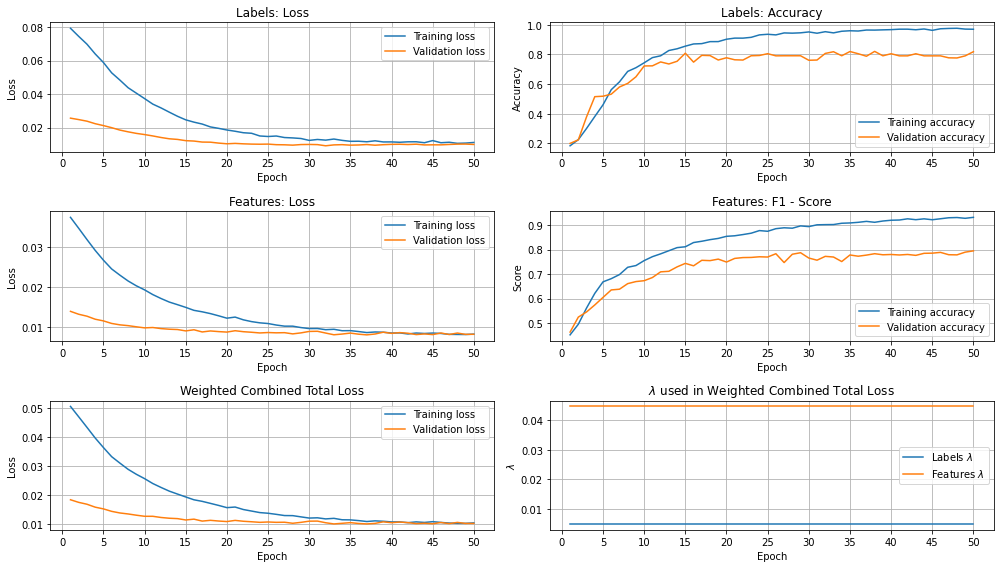

In [ ]:
# Initialize Net
net = MTLNet(NUM_CLASSES, NUM_FEATURES).to(device)

# Define loss and optimizer
loss_scalar = {"labels": 0.12, "features": 1.1}
scalars = torch.Tensor([loss_scalar["labels"], loss_scalar["features"]])

params_to_update = []
for name,param in net.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

class_weights = calc_multiclass_weights(trainset.dataframe, device)  # Adjust for data imbalance
criterion_labels = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean') #loss for labels

feature_weights = calc_multilabel_weights(trainset.dataframe, device)
criterion_features = nn.BCEWithLogitsLoss(pos_weight = feature_weights)

optimizer = optim.SGD(params_to_update, lr = 0.00035, momentum = 0.9, weight_decay = 0.05)
# optimizer.add_param_group({'params': scalars}) # to train scalars

# Train net
l_tracker, f_tracker, loss_tracker = train_MTL_net(net, criterion_labels, 
                                                   criterion_features, optimizer,
                                                   device, scalars, trainloader,
                                                   validationloader, validation_on=True,
                                                   num_epoch = 50, eval_every = 1, 
                                                   plt_on = True)

# Test net
l_results, f_results = k_results = test_MTL_net(net, testloader, device)


In [ ]:
# Test MTL net
l_results, f_results = k_results = test_MTL_net(net, testloader, device)

l_f1 = f1_score(l_results["targets"], l_results["preds"], average = "weighted")
f_f1 = f1_score(f_results["targets"], f_results["preds"], average = "samples")

print(f"\nLabels Test:   F1 Score = {l_f1*100:.3f}%")
print(f"\nFeatures Test: F1 Score = {f_f1*100:.3f}%")


Labels Test:   F1 Score = 71.496%

Features Test: F1 Score = 74.348%


In [ ]:
# Test MTL net train
l_results, f_results = k_results = test_MTL_net(net, trainloader, device)

l_f1 = f1_score(l_results["targets"], l_results["preds"], average = "weighted")
f_f1 = f1_score(f_results["targets"], f_results["preds"], average = "samples")

print(f"\nLabels Test:   F1 Score = {l_f1*100:.3f}%")
print(f"\nFeatures Test: F1 Score = {f_f1*100:.3f}%")


Labels Test:   F1 Score = 99.110%

Features Test: F1 Score = 95.286%


In [ ]:
# Test MTL net validation
l_results, f_results = k_results = test_MTL_net(net, validationloader, device)

l_f1 = f1_score(l_results["targets"], l_results["preds"], average = "weighted")
f_f1 = f1_score(f_results["targets"], f_results["preds"], average = "samples")

print(f"\nLabels Test:   F1 Score = {l_f1*100:.3f}%")
print(f"\nFeatures Test: F1 Score = {f_f1*100:.3f}%")


Labels Test:   F1 Score = 81.823%

Features Test: F1 Score = 79.521%


In [ ]:
# max_probs = [max(a) for a in l_results["probs"]]
# val_info = pd.DataFrame({
#     "prob": max_probs,
#     "pred": l_results["preds"],
#     "targ": l_results["targets"]
# })

# cond = (val_info.prob <= 0.4) #& (val_info.prob >= 0.4)
# for i, r in val_info[cond].iterrows():
#   print(f"{r.prob:.2f}\t{r.pred:.0f}\t{r.targ:.0f}")

In [ ]:
# # DUMP
# _save = str(input("are you sure? "))

# if _save.lower() == "yes":
#   torch.save(net, "Models/MTLNetNA_60epoch.pth")

# # LOAD
# net_loaded = torch.load("Models/MTLNet00_100epoch.pth")

are you sure? yes
